In [1]:
import pandas as pd
from pykml.factory import KML_ElementMaker as KML
from lxml import etree
#import shapefile as shp
import matplotlib.pyplot as plt
import numpy as np
import geopandas

In [2]:
file_name = 'relatorios/relatorio_84.csv'

In [3]:
df = pd.read_csv(filepath_or_buffer=file_name, sep=';', encoding= 'unicode_escape')

In [4]:
np.sum(df['Status'] == 'Em andamento')

8

In [5]:
#filtro_intervencao = df['Tipo de Intervenção'] == 'Cadastro apenas da barragem'
filtro_status1 = df['Status'] == 'Aguardando análise'
filtro_status2 = df['Status'] == 'Aguardando alterações de dados inconsistentes'
filtro_status3 = df['Status'] == 'Concedida'
filtro_status4 = df['Status'] == 'Indeferida'
filtro_status5 = df['Status'] == 'Em análise'

In [6]:
u_status = ['Concedida', 'Indeferida', 'Em análise', 'Aguardando análise', 'Aguardando alterações de dados inconsistentes']

In [7]:
sum(filtro_status3)

58

In [8]:
#df_filtrado = df[filtro_intervencao]
df_filtrado = df[filtro_status1 |filtro_status2 | filtro_status3 | filtro_status4 | filtro_status5]

In [9]:
n_proc = df_filtrado.shape[0]
n_proc

111

In [10]:
#df_filtrado.head()

In [11]:
df_nomes = df_filtrado[['Número do cadastro', 'Número da portaria', 'Nome do usuário de água', 'Status', 'Data de saída do processo', 'Município']]

In [12]:
df_nomes['Prioridade'] = 'Não'
df_nomes['Nome'] = 'N/D'
df_nomes['AHE'] = 'N/D'

C:\Users\Roberto Rolo\anaconda3\envs\drh\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Roberto Rolo\anaconda3\envs\drh\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Roberto Rolo\anaconda3\envs\drh\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [13]:
nomes = pd.read_csv("nomes.csv", sep=",", encoding='utf8')

In [14]:
df_nomes.head()

,Número do cadastro,Número da portaria,Nome do usuário de água,Status,Data de saída do processo,Município,Prioridade,Nome,AHE
1,2020/014.974,-,CGH SANTO ANJO GERAÇÃO DE ENERGIA S.A,Em análise,24/09/2020,Caxias do Sul,Não,N/D,N/D
2,2020/013.600,R-001.624/2020,Z-4 Geração de Energia Elétrica,Concedida,18/08/2020,Vacaria,Não,N/D,N/D
3,2020/013.471,R-001.608/2020,Cooperativa de Geração de Energia e Desenvolvi...,Concedida,26/08/2020,Augusto Pestana,Não,N/D,N/D
6,2020/012.816,-,VALE DO TURVO HIDRELÉTRICA LTDA,Em análise,11/09/2020,Ipê,Não,N/D,N/D
7,2020/012.793,-,VALE DO TURVO HIDRELÉTRICA LTDA,Em análise,11/09/2020,Ipê,Não,N/D,N/D


In [15]:
nomes.head()

,Prioridade,Número do cadastro,AHE,Nome,Nome do usuário de água,Município,Status,Data de saída do processo,Número da portaria
0,Não,2020/014.974,CGH,Santo Anjo,CGH SANTO ANJO GERAÇÃO DE ENERGIA S.A,Caxias do Sul,Aguardando alterações de dados inconsistentes,27/08/2020,-
1,Não,2020/013.600,CGH,Passo do Buraco,Z-4 Geração de Energia Elétrica,Vacaria,Concedida,18/08/2020,R-001.624/2020
2,Não,2020/013.471,CGH,Augusto Pestana,Cooperativa de Geração de Energia e Desenvolvi...,Augusto Pestana,Concedida,26/08/2020,R-001.608/2020
3,Não,2020/012.232,CGH,Limeira,VALE DO TURVO HIDRELÉTRICA LTDA,André da Rocha,Aguardando análise,22/07/2020,-
4,Não,2020/011.687,CGH,Arroio da Reserva,SAULO SALLES BEVILACQUA NETO,Pinhal Grande,Concedida,28/08/2020,R-001.607/2020


In [16]:
for index, row in nomes.iterrows():
    num = row['Número do cadastro']
    name = row['Nome']
    ahe = row['AHE']
    for index1, row1 in df_nomes.iterrows():
        num1 = row1['Número do cadastro']
        if num == num1:
            df_nomes.loc[index1, 'Nome'] = name
            df_nomes.loc[index1, 'AHE'] = ahe

C:\Users\Roberto Rolo\anaconda3\envs\drh\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Roberto Rolo\anaconda3\envs\drh\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Roberto Rolo\anaconda3\envs\drh\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i

In [17]:
df_nomes.head()

,Número do cadastro,Número da portaria,Nome do usuário de água,Status,Data de saída do processo,Município,Prioridade,Nome,AHE
1,2020/014.974,-,CGH SANTO ANJO GERAÇÃO DE ENERGIA S.A,Em análise,24/09/2020,Caxias do Sul,Não,Santo Anjo,CGH
2,2020/013.600,R-001.624/2020,Z-4 Geração de Energia Elétrica,Concedida,18/08/2020,Vacaria,Não,Passo do Buraco,CGH
3,2020/013.471,R-001.608/2020,Cooperativa de Geração de Energia e Desenvolvi...,Concedida,26/08/2020,Augusto Pestana,Não,Augusto Pestana,CGH
6,2020/012.816,-,VALE DO TURVO HIDRELÉTRICA LTDA,Em análise,11/09/2020,Ipê,Não,N/D,N/D
7,2020/012.793,-,VALE DO TURVO HIDRELÉTRICA LTDA,Em análise,11/09/2020,Ipê,Não,N/D,N/D


In [18]:
df_filtrado['Nome'] = df_nomes['Nome']
df_filtrado['AHE'] = df_nomes['AHE']

C:\Users\Roberto Rolo\anaconda3\envs\drh\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Roberto Rolo\anaconda3\envs\drh\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [19]:
df_nomes = df_nomes[['Prioridade', 'Número do cadastro', 'AHE', 'Nome', 'Nome do usuário de água', 'Município', 'Status', 'Data de saída do processo', 'Número da portaria']]

In [20]:
df_nomes.head()

,Prioridade,Número do cadastro,AHE,Nome,Nome do usuário de água,Município,Status,Data de saída do processo,Número da portaria
1,Não,2020/014.974,CGH,Santo Anjo,CGH SANTO ANJO GERAÇÃO DE ENERGIA S.A,Caxias do Sul,Em análise,24/09/2020,-
2,Não,2020/013.600,CGH,Passo do Buraco,Z-4 Geração de Energia Elétrica,Vacaria,Concedida,18/08/2020,R-001.624/2020
3,Não,2020/013.471,CGH,Augusto Pestana,Cooperativa de Geração de Energia e Desenvolvi...,Augusto Pestana,Concedida,26/08/2020,R-001.608/2020
6,Não,2020/012.816,N/D,N/D,VALE DO TURVO HIDRELÉTRICA LTDA,Ipê,Em análise,11/09/2020,-
7,Não,2020/012.793,N/D,N/D,VALE DO TURVO HIDRELÉTRICA LTDA,Ipê,Em análise,11/09/2020,-


df_nomes = df_nomes.reindex()

def criar_nome(lista):
    nome = ' '.join(lista)
    return nome

tipo = [i.split()[0] for i in df_nomes['Nome']]
nome = [criar_nome(i.split()[1:]) for i in df_nomes['Nome']]

df_nomes['Nome'] = nome

df_nomes.insert(2, 'AHE', tipo,  allow_duplicates=True)

df_nomes.head()

In [21]:
df_nomes.to_csv('nomes_dumped.csv', index=False)
df_nomes.to_excel('processos_siout.xlsx', index=False, sheet_name='SIOUT')

In [22]:
aguardando = df_filtrado[df_filtrado['Status'] == 'Aguardando análise'][['Número do cadastro', 'Nome do usuário de água', 'Data de início do cadastro', 'Data de saída do processo']]
aguardando['Data de saída do processo'] = pd.to_datetime(aguardando['Data de saída do processo'], dayfirst=True)
aguardando['Data de início do cadastro'] = pd.to_datetime(aguardando['Data de início do cadastro'], dayfirst=True)
aguardando.sort_values('Data de saída do processo')
aguardando.to_csv('aguardando_analise.csv', index=False)
aguardando

,Número do cadastro,Nome do usuário de água,Data de início do cadastro,Data de saída do processo
56,2019/021.085,Hidrotermica s/a.,2019-10-28,2020-07-31
126,2018/027.596,Companhia Estadual de Geração e Transmissão de...,2018-09-19,2020-09-25


In [23]:
aguardando = df_filtrado[df_filtrado['Status'] == 'Em análise'][['Número do cadastro', 'Nome do usuário de água', 'Data de início do cadastro', 'Data de saída do processo']]
aguardando['Data de saída do processo'] = pd.to_datetime(aguardando['Data de saída do processo'], dayfirst=True)
aguardando['Data de início do cadastro'] = pd.to_datetime(aguardando['Data de início do cadastro'], dayfirst=True)
aguardando.sort_values('Data de saída do processo')
aguardando.to_csv('em_analise.csv', index=False)
aguardando

,Número do cadastro,Nome do usuário de água,Data de início do cadastro,Data de saída do processo
1,2020/014.974,CGH SANTO ANJO GERAÇÃO DE ENERGIA S.A,2020-08-24,2020-09-24
6,2020/012.816,VALE DO TURVO HIDRELÉTRICA LTDA,2020-07-29,2020-09-11
7,2020/012.793,VALE DO TURVO HIDRELÉTRICA LTDA,2020-07-29,2020-09-11
102,2018/034.955,Enel Brasil S.A,2018-12-19,2020-09-09
184,2017/028.636,CENTRAL GERADORA HIDRELÉTRICA FORQUILHA LTDA.,2017-09-09,2020-09-11


In [24]:
shp_path = "estados_2010.shp"
#sf = shp.Reader(shp_path)

In [25]:
bacias_path = "Bacia_Hidrografica.shp"
bacias = geopandas.read_file(bacias_path, )

In [26]:
#bacias.head()

In [27]:
estados = geopandas.read_file(shp_path)

In [28]:
#sf.records()[22]

In [29]:
def plot_shape(idt, ax, sf):
    shape_ex = sf.shape(idt)
    x_lon = np.zeros((len(shape_ex.points),1))
    y_lat = np.zeros((len(shape_ex.points),1))
    for ip in range(len(shape_ex.points)):
        x_lon[ip] = shape_ex.points[ip][0]
        y_lat[ip] = shape_ex.points[ip][1]
    ax.plot(x_lon,y_lat,c='gray') 
    x0 = np.mean(x_lon)
    y0 = np.mean(y_lat)

In [30]:
pie_dict = {}
for s in u_status:
    ns = sum(df_filtrado['Status'] == s)
    if ns > 0:
        pie_dict[s] = ns

In [31]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

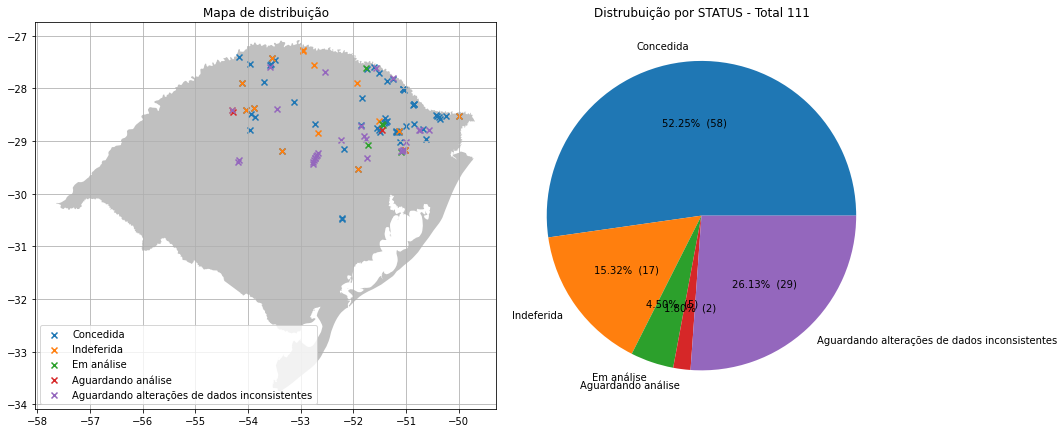

In [32]:
plt.rcParams['figure.facecolor'] = 'white'
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,10), gridspec_kw={'width_ratios': [1, 0.84]})
#fig.suptitle('Processos de hidrelétricas do SIOUT', size=16)
ax2.pie(pie_dict.values(), autopct=make_autopct(pie_dict.values()), labels=pie_dict.keys())
#plot_shape(22, ax1, sf)
estados[estados['sigla'] == 'RS'].plot(color='silver', ax=ax1, alpha=1)
#bacias.plot(edgecolor='black', color='gray', ax=ax1, alpha=0.1)
for s in u_status:
    f = df_filtrado['Status'] == s
    y, x = df_filtrado[f]['Latitude'].values, df_filtrado[f]['Longitude'].values
    x, y = [float(i.replace(',','.')) for i in x], [float(i.replace(',','.')) for i in y]
    ax1.scatter(x, y, label = s, marker='x')
ax1.axis('scaled')
ax1.set_title('Mapa de distribuição')
ax2.set_title('Distrubuição por STATUS - Total {}'.format(n_proc))
ax1.legend()
ax1.grid()
fig.tight_layout()
plt.savefig('Status', bbox_inches='tight', transparent=False)
plt.show()

In [33]:
doc = KML.Document()

In [34]:
icons = {
    'verde':'http://maps.google.com/mapfiles/kml/pushpin/grn-pushpin.png',
    'amarelo':'http://maps.google.com/mapfiles/kml/pushpin/ylw-pushpin.png',
    'vermelho':'http://maps.google.com/mapfiles/kml/pushpin/red-pushpin.png'
}

In [35]:
for color in icons:
    
    s = KML.Style(
            KML.IconStyle(
                KML.scale(1.2),
                KML.Icon(
                    KML.href(icons[color])
                ),
            ),
            id=color,
        )
    
    doc.append(s)

In [36]:
fld_ag_doc = KML.Folder(KML.name('Aguardando formalização de documentos'))
fld_ag_an = KML.Folder(KML.name('Aguardando análise'))
fld_ag_alt = KML.Folder(KML.name('Aguardando alterações de dados inconsistentes'))
fld_an = KML.Folder(KML.name('Em análise'))
fld_conc = KML.Folder(KML.name('Concedida'))
fld_ind = KML.Folder(KML.name('Indeferida'))

In [37]:
for index, row in df_filtrado.iterrows():
    nome=row['AHE']+' '+row['Nome']
    name = row['Número do cadastro']
    usuario = row['Nome do usuário de água']
    status = row['Status']
    corpo_hidrico = row['Corpo Hídrico']
    municipio = row['Município']
    description = '''
Processo: {}
Usuario: {}
Status: {}
Municipio: {}
Corpo Hidrico: {}
    '''.format(name, usuario, status, municipio, corpo_hidrico)
    long = row['Latitude'].replace(',','.')
    lat = row['Longitude'].replace(',','.')
    coordinates = lat+','+long
    
    if status == 'Concedida':
        style = '#verde'
    elif status == 'Indeferida':
        style = '#vermelho'
    else:
        style = '#amarelo'
    
    p = KML.Placemark(
        KML.name(nome),
        KML.Point(KML.coordinates(coordinates)),
        KML.description(description),
        KML.styleUrl(style))
    
    if status == 'Aguardando formalização de documentos':
        fld_ag_doc.append(p)
    elif status == 'Aguardando análise':
        fld_ag_an.append(p)
    elif status == 'Aguardando alterações de dados inconsistentes':
        fld_ag_alt.append(p)
    elif status == 'Em análise':
        fld_an.append(p)
    elif status == 'Concedida':
        fld_conc.append(p)
    elif status == 'Indeferida':
        fld_ind.append(p)

In [38]:
doc.append(fld_ag_doc)
doc.append(fld_ag_an)
doc.append(fld_ag_alt)
doc.append(fld_an)
doc.append(fld_conc)
doc.append(fld_ind)

In [39]:
kml_file_path = 'hidreletricas_SIOUT.kml'

In [40]:
kml_str = etree.tostring(doc, pretty_print=True).decode('utf-8')

In [41]:
f = open(kml_file_path, "w")
f.write(kml_str)
f.close()